In [1]:
import sys 
sys.path.append("..")
from src.dataset import Dataset
import pandas as pd
import numpy as np
from definitions import *
import copy

import matplotlib.pyplot as plt

import warnings

# Suppress LightGBM categorical_feature warning
warnings.filterwarnings("ignore", category=UserWarning, message="categorical_feature keyword has been found*")
warnings.filterwarnings("ignore", category=UserWarning, message="categorical_feature in param dict is overridden*")



RUNNING ON GPU


In [2]:
adult_dataset_generator = Dataset("adult")
all_data = adult_dataset_generator.original_dataframe.copy()

In [3]:
sampling_method = "protected"


arrays = np.load('../results/arrays/arrays_{}.npz'.format(sampling_method))
average = arrays['average']
std = arrays['std']
feat_imp_average = arrays['feat_imp_average']
feat_imp_std = arrays['feat_imp_std']

feature_names = ['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [4]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, true_positive_rate_difference, true_positive_rate, false_positive_rate_difference
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

def eq_odd(y_test, y_pred, group_test):
    return true_positive_rate_difference(y_test, y_pred, sensitive_features=group_test)\
                + false_positive_rate_difference(y_test, y_pred, sensitive_features=group_test)

problem_classification = {"metrics":[accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score],
                      "metric_names":["Accuracy", "P", "R", "F1", "ROC AUC"],
                      "fairness_metrics": [eq_odd],
                      "fairness_metric_names": ["Equalized odds"],
                      "generative_methods": ["tvae", "cart", "smote"],}



problem_classification = {"metrics":[accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score],
                      "metric_names":["Accuracy", "P", "R", "F1", "ROC AUC"],
                      "fairness_metrics": [eq_odd],
                      "fairness_metric_names": ["Equalized odds"],
                      "generative_methods": ["tvae", "cart", "smote"],}
                      



# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


categorical_cols = adult_dataset_generator.categorical_input_cols.copy()
categorical_cols.remove("sex")

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, adult_dataset_generator.continuous_input_cols),
        ('cat', categorical_transformer, categorical_cols)])


# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_RF = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier(random_state=42))])
clf_DT = Pipeline(steps=[('preprocessor', transformations),
                    ('classifier', DecisionTreeClassifier(random_state=42))])     


model_names_classification = ["LightGBM", "XGBoost", "Catboost", "Decission Tree", "Random Forest"]


models_classification = [LGBMClassifier, xgb.XGBClassifier, CatBoostClassifier, clf_DT, clf_RF]

args = [{"categorical_feature":adult_dataset_generator.categorical_input_cols, "verbose":-1}, {"enable_categorical":True, "tree_method":'hist'}, {"random_state":42, "loss_function":"Logloss", "verbose":False, "iterations":100, "learning_rate":0.01, "cat_features":adult_dataset_generator.categorical_input_cols}, {}, {}]

problems_classification = []
for model, name, arg in zip(models_classification, model_names_classification, args):
    problem = problem_classification.copy()
    problem["model"] = copy.deepcopy(model)
    problem["model_name"] = name
    problem["args"] = arg
    problems_classification.append(problem)

In [5]:
metric_names_actual = [r"Accuracy $\uparrow$", r"F1 $\uparrow$", r"ROC AUC $\uparrow$", r"Equalized Odds $\downarrow$"]

metrics_optimal = ["max", "max", "max", "min"]
names_train = ["Adult", "Augmented Adult (TVAE)", "Augmented Adult (CART)", "Augmented Adult (SMOTENC)"]
test_sets, _ = adult_dataset_generator.split_population(all_data)
protected_attributes = ["Sex"]
# names_test = [f"Sex={value}" for value in test_sets.keys()]
names_test = []
names_test.append("Overall")


latex_table = generate_latex_table_max(average, std, names_train, names_test, problems_classification, metric_names_actual=metric_names_actual, test_data=True, metrics_optimal=metrics_optimal, sampling_method=sampling_method)
print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{l l c c c c}
\hline
Model & Train data & \multicolumn{4}{c}{Test data} \\
&  & \multicolumn{4}{c}{Overall}\\
\cline{3-6}&  & Accuracy $\uparrow$ & F1 $\uparrow$ & ROC AUC $\uparrow$ & Equalized Odds $\downarrow$ \\
\hline\multirow{5}{*}{LightGBM} & \multirow{1}{*}{Adult} & \textbf{0.872} \scriptsize{$\pm$ 0.003} & \textbf{0.713} \scriptsize{$\pm$ 0.007} & \textbf{0.800} \scriptsize{$\pm$ 0.006} & \textbf{0.123} \scriptsize{$\pm$ 0.015} \\
 & \multirow{1}{*}{Augmented Adult (TVAE)} & \textbf{0.872} \scriptsize{$\pm$ 0.003} & \underline{0.711} \scriptsize{$\pm$ 0.007} & \underline{0.798} \scriptsize{$\pm$ 0.006} & 0.140 \scriptsize{$\pm$ 0.019} \\
 & \multirow{1}{*}{Augmented Adult (CART)} & \textbf{0.872} \scriptsize{$\pm$ 0.004} & \underline{0.711} \scriptsize{$\pm$ 0.008} & \underline{0.798} \scriptsize{$\pm$ 0.006} & \underline{0.128} \scriptsize{$\pm$ 0.020} \\
 & \multirow{1}{*}{Augmented Adult (SMOTENC)} & \textbf{0.872} \scriptsize{$\pm

In [6]:
feat_imp_average.shape

(5, 4, 1, 11)

/tmp/ipykernel_181351/1964955788.py:41: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=5)  # Adjust the spacing between subplots


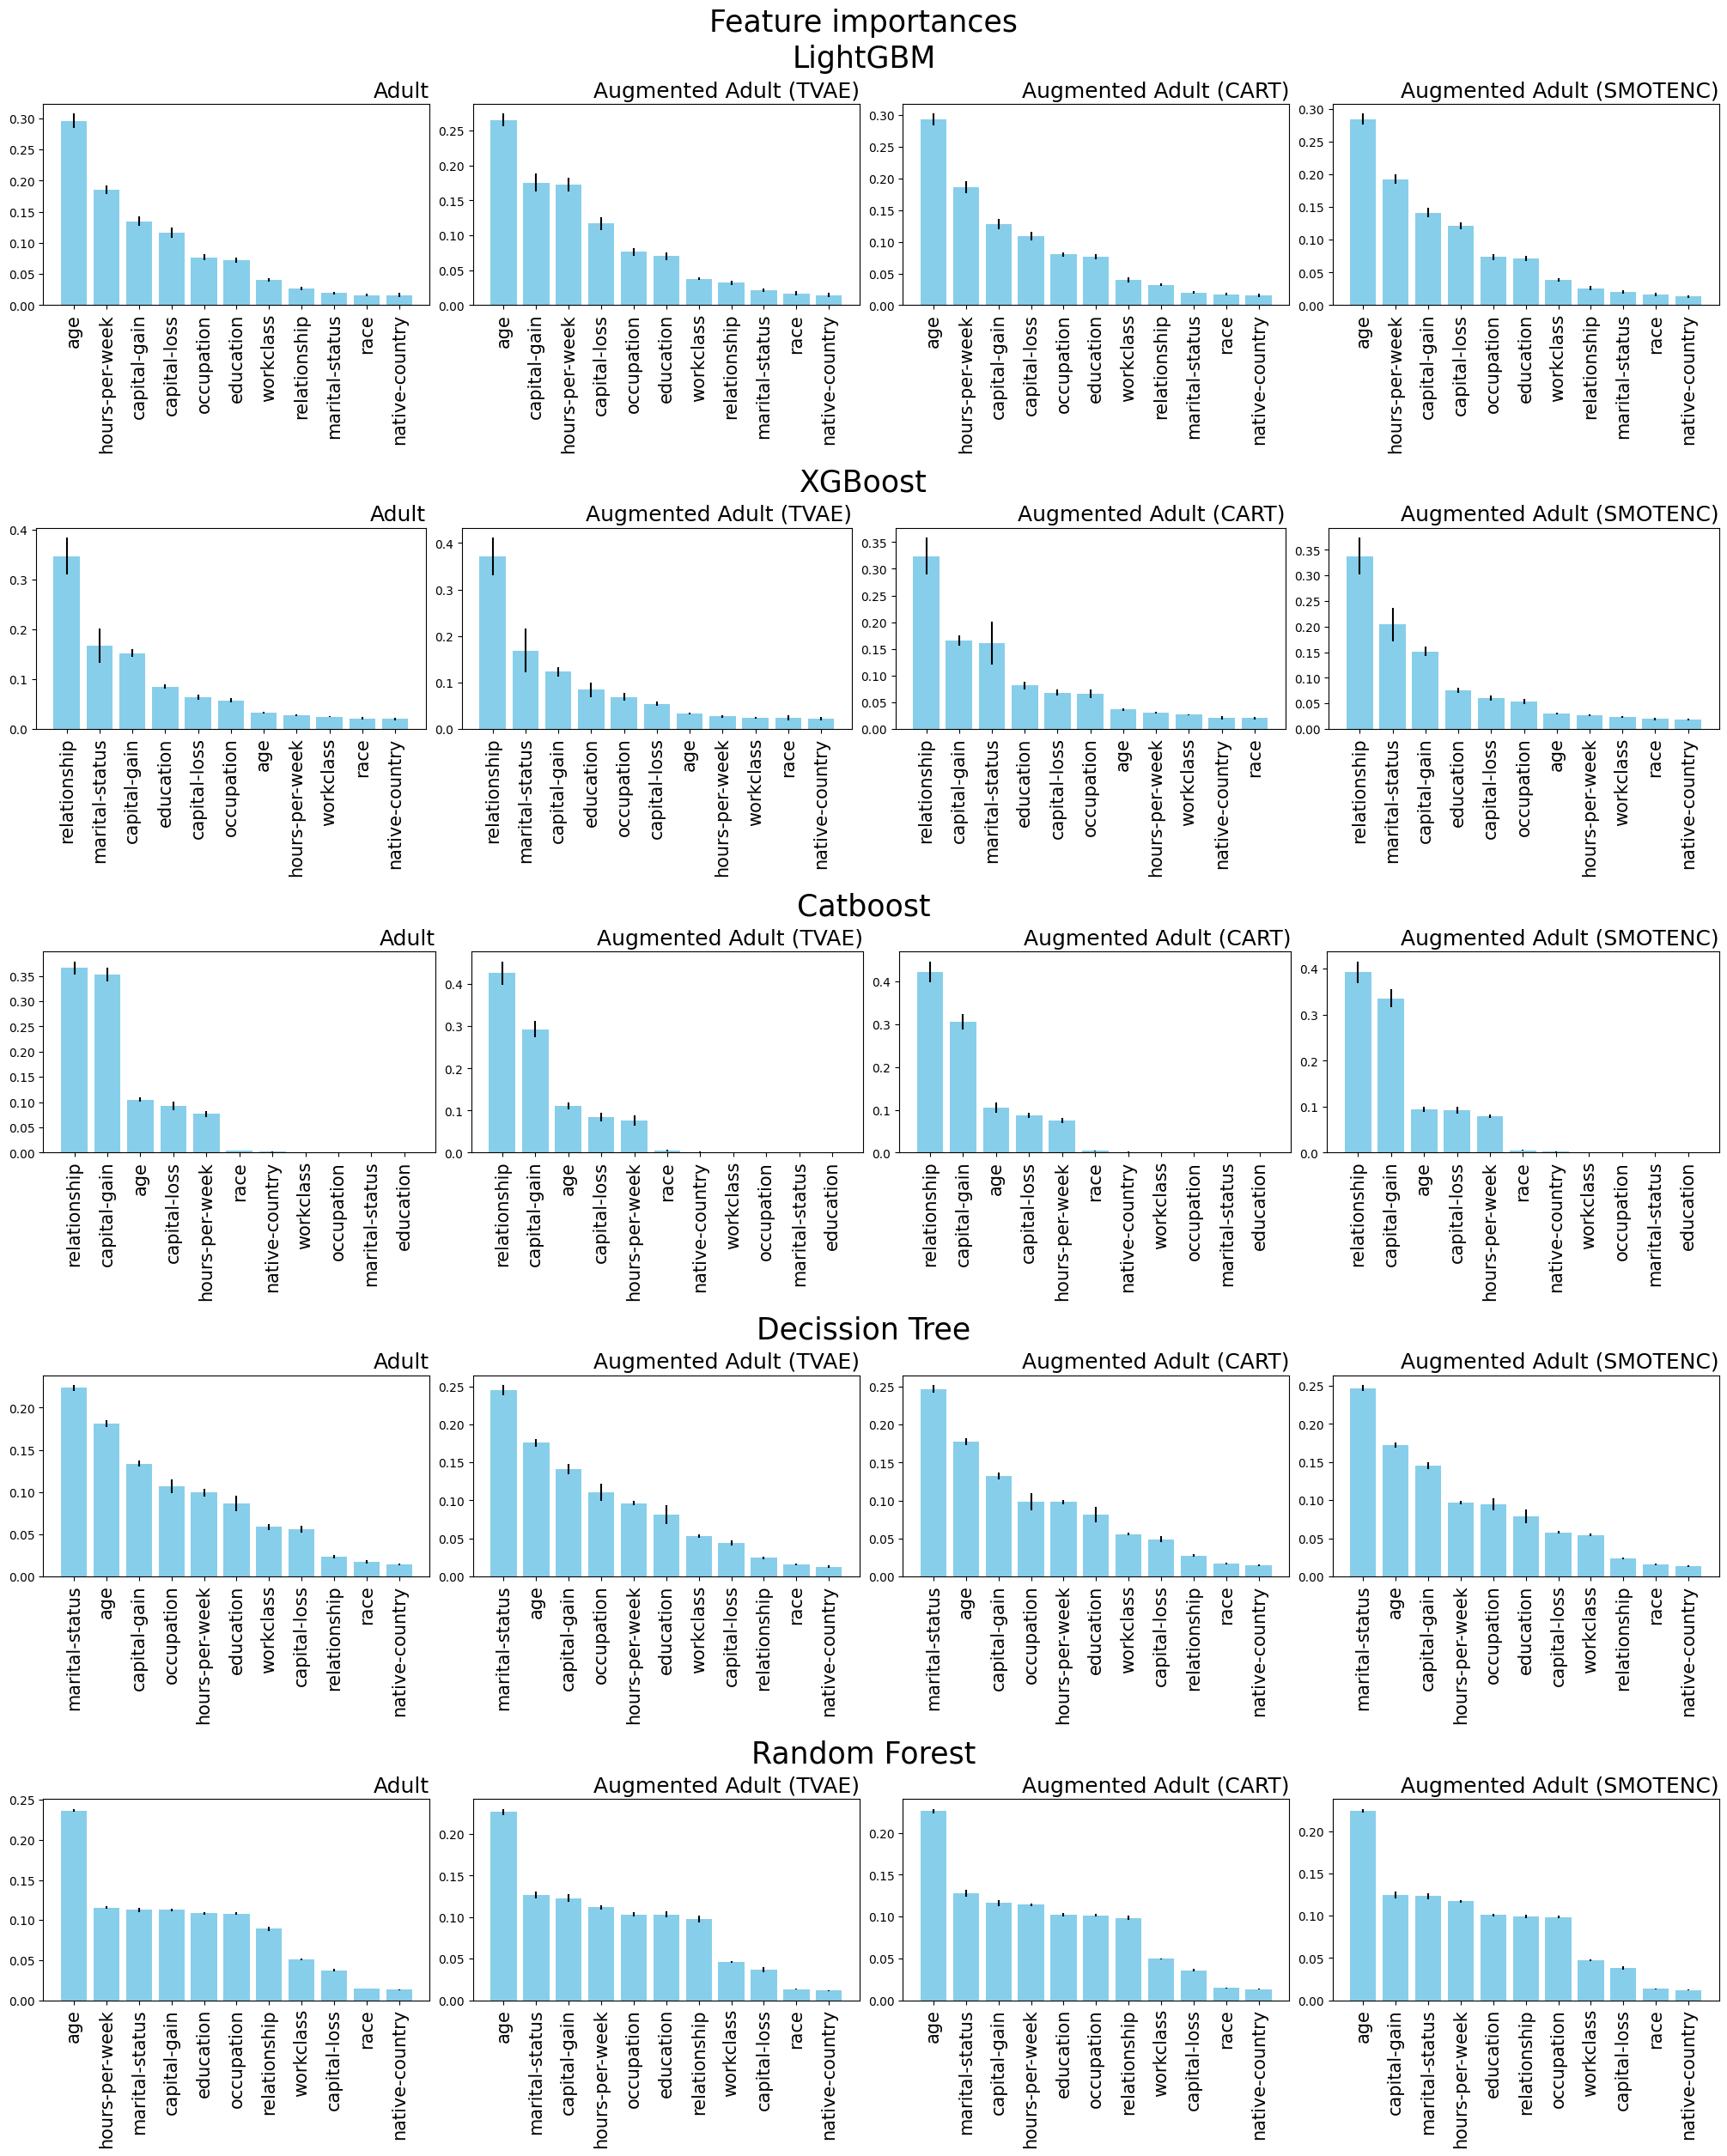

In [7]:
import matplotlib.pyplot as plt

# Assuming you have defined problems_classification, names_train, feat_imp_average, and feature_names

num_problems = len(problems_classification)
num_train_sets = len(names_train)

scale = 5
fontsize_title= 25
fontsize_suptitle= 18
fontsize_tick= 15
fig = plt.figure(constrained_layout=True, figsize=(scale*num_train_sets, scale*num_problems))
fig.suptitle('Feature importances', fontsize=fontsize_title)

# Create subfigures
subfigs = fig.subfigures(nrows=num_problems, ncols=1)

for row, subfig in enumerate(subfigs):
    problem_name = problems_classification[row]["model_name"]
    subfig.suptitle(problem_name, fontsize=fontsize_title)

    # Create subplots per subfigure
    axs = subfig.subplots(nrows=1, ncols=num_train_sets)

    for col, ax in enumerate(axs):
        train_name = names_train[col]
        feature_importances_avg = feat_imp_average[row][col][0]
        feature_importances_std = feat_imp_std[row][col][0]  # Update this line to access std
        sorted_lists = sorted(zip(feature_importances_avg, feature_importances_std, feature_names), reverse=True)
        sorted_feature_importances_avg, sorted_feature_importances_std, sorted_feature_names = zip(*sorted_lists)

        # print(sorted_feature_importances_avg)
        # print(sorted_feature_importances_std)
        ax.bar(sorted_feature_names, sorted_feature_importances_avg, color='skyblue', yerr=sorted_feature_importances_std)
        # ax.set_xlabel('Features')
        # ax.set_ylabel('Frequency')
        ax.set_title(train_name, fontsize=fontsize_suptitle, loc='right')  # Add train_name as subplot title
        ax.tick_params(axis='x', rotation=35)
        ax.tick_params(axis='x', labelsize=fontsize_tick, labelrotation=90)  # Decrease the font size of x-ticks

plt.subplots_adjust(hspace=5)  # Adjust the spacing between subplots
plt.savefig("../results/feature_importance/feature_importance_{}.jpg".format(sampling_method), dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()


In [12]:
protected_attributes = ["sex"]
split_dfs, additional_sizes = adult_dataset_generator.split_population(adult_dataset_generator.original_dataframe, protected_attributes)

split_df_keys, split_df_vals = zip(*split_dfs.items())

augmented_dfs, augmented_dfs_plot = get_synthetic_splits(adult_dataset_generator, split_dfs, generative_method="cart", generative_seed=0, return_plot=True, sampling_method=sampling_method)


final_augmented_dataset = pd.concat(augmented_dfs)
final_augmented_dataset_plot = pd.concat(augmented_dfs_plot)

final_augmented_dataset_plot['income_method'] = final_augmented_dataset_plot['income'].astype(str) + ' (' + final_augmented_dataset_plot['method'] + ')'



category


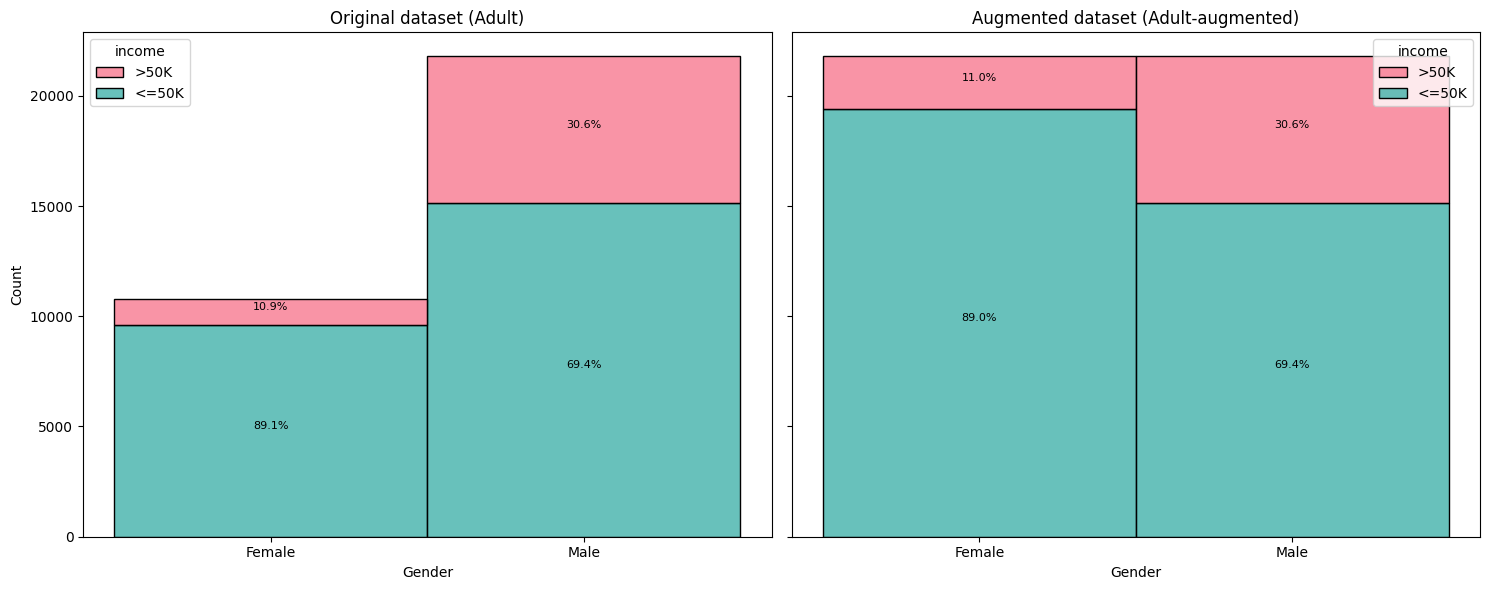

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have two different DataFrames: df1 and df2
# Replace df1 and df2 with your actual DataFrame names

# Set up the plot with two subplots in two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# Define the palette using Seaborn's color palette generator
palette = sns.color_palette("husl", 2)  # Using 'husl' palette with 2 colors

gender_order = ['Female', 'Male']  # Adjust as per your actual category order

# Plot for df1
sns.histplot(data=adult_dataset_generator.original_dataframe, x='sex', hue='income', palette=palette, hue_order=['>50K', '<=50K'], multiple="stack", ax=axes[0], discrete = True)
axes[0].set_title('Original dataset (Adult)')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

# Plot for df2
sns.histplot(data=final_augmented_dataset_plot, x='sex', hue='income', palette=palette, hue_order=['>50K', '<=50K'], multiple="stack", ax=axes[1], discrete = True)
axes[1].set_title('Augmented dataset (Adult-augmented)')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

for ax in axes:
    for bar in ax.patches:
        # Find the total height of bars for the current x-coordinate
        total_height = sum(p.get_height() for p in ax.patches if p.get_x() == bar.get_x())
        # Calculate the percentage
        percentage = (bar.get_height() / total_height) * 100
        # Annotate the bar with the percentage
        ax.annotate(f'{percentage:.1f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.savefig("../results/sampling/{}.jpg".format(sampling_method), dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()
